# Transformer
* 2017年,Transformer横空出世,至今已经8年时间,仍然没有新的框架可以超越
## 1.准备工作
### 1.1 机器翻译和数据集

In [2]:
import os
import torch
from d2l import torch as d2l
import zipfile

d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

def read_data_nmt():
    """载入"英语-法语"数据集"""
    # 指定下载目录为当前目录下的data/fra-eng文件夹
    download_dir = './data/fra-eng/'
    
    # 确保下载目录存在
    os.makedirs(download_dir, exist_ok=True)
    
    # 下载ZIP文件
    zip_path = d2l.download('fra-eng', cache_dir=download_dir)
    
    # 解压文件到当前下载目录
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(download_dir)
    
    # 正确路径应该是下载目录中的fra.txt
    data_file = os.path.join(download_dir, 'fra-eng/fra.txt')
    
    # 读取数据文件   
    with open(data_file, 'r', encoding='utf-8') as f:
        return f.read()

text = read_data_nmt()
print(text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



* 数据集预处理

In [6]:
def preprocess_nmt(text):
    """预处理“英语－法语”数据集"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


* 词元化

这里使用单词级词元化而非字符级词元化

In [7]:
#@save
def tokenize_nmt(text, num_examples=None):
    """词元化“英语－法语”数据数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

* 创建词表

In [8]:
src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

* 截断和填充限制大小

语言预测模型中，序列样本有固定的长度，由num_steps决定，对于不同文本序列长度的数据，使用截断和填充

In [9]:
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

print(truncate_pad(source[0], 10, ['<pad>']))
truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

['go', '.', ['<pad>'], ['<pad>'], ['<pad>'], ['<pad>'], ['<pad>'], ['<pad>'], ['<pad>'], ['<pad>']]


[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

* 将文本序列转换成小批量数据集

In [10]:
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

* 整合上述功能返回数据迭代器

In [11]:
#@save
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [12]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('X的有效长度:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('Y的有效长度:', Y_valid_len)
    break

X: tensor([[ 7, 84,  4,  3,  1,  1,  1,  1],
        [ 0,  5,  3,  1,  1,  1,  1,  1]], dtype=torch.int32)
X的有效长度: tensor([4, 3])
Y: tensor([[  6,  33,  17,   4,   3,   1,   1,   1],
        [114,   5,   3,   1,   1,   1,   1,   1]], dtype=torch.int32)
Y的有效长度: tensor([5, 3])


### 1.2 编码器和解码器

* 编码器

In [13]:
from torch import nn

class Encoder(nn.Module):
    """编码器"""
    def __init__(self):
        super(Encoder, self).__init__()
        # 这里可以添加编码器的具体实现
    def forward(self, X, *args):
        # 这里可以添加前向传播的具体实现
        raise NotImplementedError("Encoder forward method not implemented")

* 解码器

In [14]:
class Decoder(nn.Module):
    """解码器"""
    def __init__(self):
        super(Decoder, self).__init__()
        # 这里可以添加解码器的具体实现
    def init__state(self, enc_outputs,*args):
        """初始化解码器状态"""
        # 这里可以添加解码器状态初始化的具体实现
        raise NotImplementedError("Decoder state initialization not implemented")
    def forward(self, X, *args):
        # 这里可以添加前向传播的具体实现
        raise NotImplementedError("Decoder forward method not implemented")

* 合并编码器和解码器

In [15]:
class EncoderDecoder(nn.Module):
    """编码器-解码器"""
    def __init__(self, encoder, decoder):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X):
        enc_outputs = self.encoder(enc_X)
        dec_state = self.decoder.init_state(enc_outputs)
        return self.decoder(dec_X, dec_state)

### 1.3 序列到序列学习

In [16]:
import collections
import math
import torch as T
from torch import nn
from d2l import torch as d2l
from matplotlib import pyplot as plt

* 编码器

这里的嵌入层的作用是对输入的序列数据进行编码

我们在前面使用独热向量进行编码，但在这个任务中，语料库的长度达到了10万，独热向量的长度为10万，对应的RNN输入层的参数是100000 * num_hiddens，这显然是不可接受的。

embedding嵌入层使用一个vocab_size * embed_size的随机矩阵进行降维，控制输入参数到embed_size上

In [17]:
class Seq2SeqEncoder(nn.Module):
    """序列到序列编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0.0):
        super(Seq2SeqEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                           dropout=dropout)

    def forward(self, X):
        X = self.embedding(X)
        X = X.permute(1, 0, 2)  # 转换为 (时间步, 批量大小, 嵌入维度)
        output, state = self.rnn(X)
        return output, state

In [ ]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
print("嵌入层随机矩阵的大小：",encoder.embedding.weight.shape)  # 查看嵌入层的权重形状
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
print("输出向量大小：",output.shape) # 对应时间步，批量大小为4，隐藏层大小为16
print("状态向量大小：",state.shape) # 对应层数为2，批量大小为4，隐藏层大小为16
output.permute(1,0,2)[:,-1,:] == state[1]

嵌入层随机矩阵的大小： torch.Size([10, 8])
输出向量大小： torch.Size([7, 4, 16])
状态向量大小： torch.Size([2, 4, 16])


tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True]])

* 解码器

解码器的RNN输入是编码器输出的隐状态（num_layers * batch_size * num_hiddens）增广后变为的（时间步 * batch_size * num_hiddens）

与输入的目标的embedding编码后的(时间步 * batch_size * embed_size)拼接

输入为(时间步 * batch_size * (embed_size + num_hiddens))

这里有个译文是编码器和解码器采用一套num_hiddens参数

In [19]:
class Seq2SeqDecoder(nn.Module):
    """序列到序列解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0.0):
        super(Seq2SeqDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                           dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs):
        return enc_outputs[1]  # 返回编码器的最后一个状态

    def forward(self, X, state):
        X = self.embedding(X)
        X = X.permute(1, 0, 2)  # 转换为 (时间步, 批量大小, 嵌入维度)
        context = state[-1].repeat(X.shape[0], 1, 1)  # 扩展上下文向量
        X = T.cat((X, context), dim=2)  # 拼接上下
        output, state = self.rnn(X, state)
        output = self.dense(output)
        output = output.permute(1, 0, 2)
        # output的形状为 (批量大小, 时间步, 词汇表大小)
        # state的形状为 (num_layers, batch_size, num_hiddens)
        return output, state

In [20]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

* 损失函数

In [21]:
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

注意nn.CrossEntropyLoss(y_hat,y)的输入y_hat的格式应该为(batchsize,N,....)其中N为类别数目

In [22]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        
        # 设置为非聚合，方便后续舍弃没用的损失
        self.reduction='none'
        
        # permute(0, 2, 1) 将 pred 的维度重排为 (batch_size, vocab_size, num_steps)
        # label的形状为 (batch_size, num_steps)
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        # unweighted_loss 的形状为 (batch_size, num_steps)，
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        # 返回的 weighted_loss 的形状为 (batch_size,)
        return weighted_loss


* 训练

In [23]:
def train_seq2seq(net,data_dir,lr,num_epochs,tgt_vocab,device):
    """训练序列到序列模型"""
    # 这里可以添加训练代码
    # net: 序列到序列模型
    # data_dir: 数据目录
    # lr: 学习率
    # num_epochs: 训练轮数
    # tgt_vocab: 目标词汇表
    # device: 设备（CPU或GPU）
    def xavier_init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)  # 偏置初始化为零
        elif isinstance(m, nn.GRU):
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
                elif "bias" in param:
                    nn.init.zeros_(m._parameters[param])  # 偏置初始化为零
                    
    net.apply(xavier_init_weights)  # 初始化权重
    net.to(device)  # 将模型移动到指定设备
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)  # 优化器
    loss = MaskedSoftmaxCELoss()  # 损失函数
    epoch_losses = []    # 存放每个 epoch 的 loss
    
    net.train()  # 设置模型为训练模式
    epoch_losses = []  # 用于记录每个 epoch 的损失

    for epoch in range(num_epochs):
        total_loss = 0  # 初始化每个 epoch 的总损失
        num_batches = 0  # 记录当前 epoch 的批次数

        for batch in data_dir:
            optimizer.zero_grad()
            
            # 获取批量数据并将其移动到指定设备
            X, _, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], 
                            device=device).reshape(-1, 1)
            dec_X = torch.cat((bos, Y[:, :-1]), dim=1)
            
            Y_hat, _ = net(X, dec_X)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            d2l.grad_clipping(net, 1)
            optimizer.step()
            
            # 累加损失
            total_loss += l.sum().item()  # 使用 .item() 获取标量值
            num_batches += Y_valid_len.sum().item()  # 增加批次数

        # 计算当前 epoch 的平均损失
        average_loss = total_loss / num_batches
        epoch_losses.append(average_loss)

        # 每 20 个 epoch 打印一次损失
        if (epoch + 1) % 50 == 0:
            print("epoch:", epoch + 1, "loss:", average_loss)
         # 训练完毕后画图
    plt.figure(figsize=(6,4))
    plt.plot(range(1, num_epochs+1), epoch_losses, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.grid(True)
    plt.show()

epoch: 50 loss: 0.0597308296614958
epoch: 100 loss: 0.02898517043418839
epoch: 150 loss: 0.02195069593784613
epoch: 200 loss: 0.020538244881718144
epoch: 250 loss: 0.02026112724223131
epoch: 300 loss: 0.019150223144627332
epoch: 350 loss: 0.018544991388887648
epoch: 400 loss: 0.017984792361433983
epoch: 450 loss: 0.01827920008625209
epoch: 500 loss: 0.01787505305596854


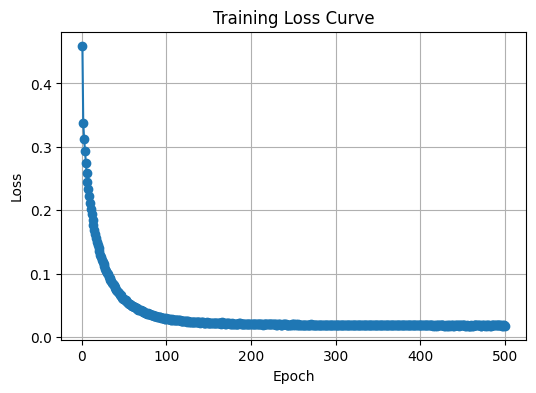

In [24]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 500, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

* 预测

预测时，解码器端只输入一个 'bos' 作为解码开始标志，接着按时间顺序迭代RNN网络，获得输入序列的翻译结果

In [25]:
#@save
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,device):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    
    # 增广，满足编码器的输入要求（批量大小为1）
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X)
    dec_state = net.decoder.init_state(enc_outputs)
    
    # 添加'批量'轴，以<bos>作为解码器的初始输入
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    
    output_seq = []
    
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        #print("解码器输出的形状:", Y.shape)
        dec_X = Y.argmax(dim=2)
        # pred的形状为(batch_size, 1)，我们需要将其转换为标量
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
        
    return ' '.join(tgt_vocab.to_tokens(output_seq))

* blue的细节没有仔细看，只知道是衡量序列翻译是否正确的一个标准

In [26]:
def bleu(pred_seq, label_seq, k):  #@save
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [27]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation = predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est mouillé ., bleu 0.658
i'm home . => je suis chez moi feu !, bleu 0.719


## 2.注意力机制

![attention](images/attention.png)

注意力机制的提出是为了解决RNN在长序列学习时的梯度消失问题。注意力机制的核心思想是通过计算输入序列中每个元素对当前输出的影响程度，来动态调整模型的关注点。

### 2.1 注意力评分函数
![attention](images/attention_score.png)


* mask操作

为了遮蔽序列中没有用的信息，超出有效长度的位置都将其遮蔽并置为0

In [28]:
def masked_softmax(X, valid_len):
    """遮蔽softmax"""
    if valid_len is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_len.dim() == 1:
            valid_len = T.repeat_interleave(valid_len, shape[1])
        else:
            valid_len = valid_len.reshape(-1)
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_len, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)
    
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.3666, 0.6334, 0.0000, 0.0000],
         [0.4715, 0.5285, 0.0000, 0.0000]],

        [[0.2727, 0.3742, 0.3532, 0.0000],
         [0.2785, 0.3741, 0.3474, 0.0000]]])

* 加性注意力
$$
a\left( {q,k} \right) = {\bf{w}}_v^T\tanh \left( {{{\bf{W}}_q}{\bf{q}} + {{\bf{W}}_k}{\bf{k}}} \right)
$$
用于查询和键所含的信息是不同长度的矢量时

* 缩放点积注意力
$$
softmax\left( {\frac{{{{\bf{Q}}^T}{\bf{K}}}}{{\sqrt d }}} \right){\bf{V}}
$$
效率更高，但需要查询和键的所含信息的维度相同

In [39]:
class DotProductAttention(nn.Module):
    """点积注意力"""
    def __init__(self, dropout=0.0):
        super(DotProductAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        """计算点积注意力
        
        参数:
        queries: 查询张量，形状为 (batch_size, num_queries, d)
        keys: 键张量，形状为 (batch_size, num_keys, d)
        values: 值张量，形状为 (batch_size, num_keys, value_dim)
        valid_lens: 有效长度张量，形状为 (batch_size,) 或 (batch_size, num_queries)

        返回:
        (加权后的值, 注意力权重)
        """
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        self.attention_weights = self.dropout(self.attention_weights)
        return torch.bmm(self.attention_weights, values)

In [42]:
queries, keys = torch.normal(0, 1, (2, 1, 2)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
valid_lens = torch.tensor([2, 6])
attention = DotProductAttention(dropout=0.5)
attention.eval()
print("输出为：",attention(queries, keys, values, valid_lens))
print("注意力输出的形状:", attention.attention_weights.shape)


输出为： tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])
注意力输出的形状: torch.Size([2, 1, 10])


### 2.2 多头注意力

在实践中，当给定相同的查询、键和值的集合时，我们希望模型可以基于相同的注意力机制学习到不同的行为，可以使用全连接层来实现可学习的线性变换的多头注意力。

![多头注意力](images/multiple_attention.png)

In [1]:
import math
import torch as T
from torch import nn
from d2l import torch as d2l

* 具体实现

In [2]:
def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数，num_heads，num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数,num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)

    # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数,num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])


#@save
def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

这里多头注意力的实质是拆分了num_hiddens层到多个头，可能是怕num_hiddens层太长了一下子注意不过来？

In [5]:
class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # 输入queries，keys，values的形状:(batch_size，查询或者“键－值”对的个数，值size)
        # 经过变换后，输出的queries，keys，values的形状:
        # (batch_size*num_heads，查询或者“键－值”对的个数，num_hiddens/num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)
        # valid_lens　的形状:(batch_size，)或(batch_size，查询的个数)
        if valid_lens is not None:
            # 在轴0，将第一项（标量或者矢量）复制num_heads次，然后如此复制第二项，然后诸如此类。
            valid_lens = T.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # output的形状:(batch_size*num_heads，查询的个数，num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)

        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [6]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens =  6, T.tensor([3, 2])
X = T.ones((batch_size, num_queries, num_hiddens))
Y = T.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

### 2.3 自注意力

自注意力是指在计算注意力时，查询、键和值都来自同一个序列。自注意力可以捕捉序列中元素之间的关系，尤其是在长序列中。
自注意力机制的输出与输入的张量形状完全相同。

这里额外记录一下注意力机制的维度变化：
假设输入query的形状为(batch_size, step1,value_size1)
key的形状为(batch_size, step2, value_size1)
value的形状为(batch_size, step2, value_size2)

则query到key的注意力计算的输出形状为(batch_size, step1, step2)
与value的形状(batch_size, step2, value_size2)相乘后，输出的形状为(batch_size, step1, value_size2)

因此当自注意力时，query、key和value的形状相同，输出的形状也与输入相同。


### 2.4 位置编码

容易想到，自注意力进行编码时会丢失相对位置信息，因此需要对输入序列进行位置编码。

由于后续位置编码信息需要与嵌入层信息进行叠加，所以位置编码的维度需要与嵌入层的维度相同。

In [6]:
class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建一个足够长的P
        self.P = T.zeros((1, max_len, num_hiddens))
        X = T.arange(max_len, dtype=T.float32).reshape(
            -1, 1) / T.pow(10000, T.arange(
            0, num_hiddens, 2, dtype=T.float32) / num_hiddens)
        self.P[:, :, 0::2] = T.sin(X)
        self.P[:, :, 1::2] = T.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

这里给出一个直观的热力图的例子

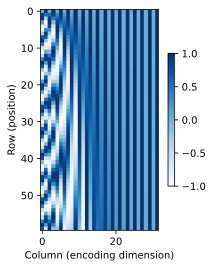

In [8]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(T.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')

P的形状为(Batch_size,num_steps,embed_size)，这里取第一个Batch作图。

列数比较大的embed_size可以理解为编码的高位，从热力图中可以看出，从低位次列到高位次列的变换频率逐渐变低，这是符合直觉的，

## 3.Transformer

自2017年横空出世，Transformer一直都普遍存在于现代的深度学习应用中，例如语言、视觉、语音和强化学习领域。

经历了一年，如今，我也终于来到这一步了。

![transformer](images/transformer.png)

编码器和解码器的连接处，键值对来自于编码器，查询来源于解码器，这和前面的Bandahu网络中采用注意力机制注意编码器RNN隐状态和解码器RNN的隐状态类似。

其他涉及到的注意力机制都为自注意力。

In [109]:
import torch as T
from torch import nn
from d2l import torch as d2l
import math
import os
import zipfile
import matplotlib.pyplot as plt

* 基于位置的前馈网络层

基于位置的含义是该网络对所有位置进行变换时采用同一套多层感知机。

In [2]:
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络层"""
    def __init__(self, num_input, num_hiddens, num_output):
        super(PositionWiseFFN, self).__init__()
        self.dense1 = nn.Linear(num_input, num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(num_hiddens, num_output)
    def forward(self, X):
        # X的形状为(batch_size, num_steps, num_input)
        return self.dense2(self.relu(self.dense1(X)))

下面的例子说明，当输入的位置相同时，输出也是相同的。

In [4]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(T.ones((2, 3, 4)))[0]

tensor([[ 0.5860,  0.0678,  0.3713,  0.1634,  0.1646,  0.0336,  0.4466, -0.3625],
        [ 0.5860,  0.0678,  0.3713,  0.1634,  0.1646,  0.0336,  0.4466, -0.3625],
        [ 0.5860,  0.0678,  0.3713,  0.1634,  0.1646,  0.0336,  0.4466, -0.3625]],
       grad_fn=<SelectBackward0>)

* 残差连接和层规范化

这里注意层规范化和前面为了防止梯度爆炸或消失使用的批量规范化略有不同：批量规范化在整个批量的数据上计算平均值和方差并进行规范化；而这里的层规范化专门针对序列数据使用，对每个样本的所有时间步计算平均值和方差并进行规范化（不同批次的序列数据可能差异巨大，有效长度是最大的制约因素，在整个批次上取平均值没有意义）。

下面例子展示了这种差别，对于ln，X的形状为num_steps * value，而对于bn，X的形状为Batch_size * value:

In [5]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = T.tensor([[1, 2], [2, 3]], dtype=T.float32)
# 在训练模式下计算X的均值和方差
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [3]:
class AddNorm(nn.Module):
    """残差连接和层规范化"""
    def __init__(self, normalized_shape, dropout=0.0):
        super(AddNorm, self).__init__()
        self.ln = nn.LayerNorm(normalized_shape)
        self.dropout = nn.Dropout(dropout)

    def forward(self, X, Y):
        # X的形状为(batch_size, num_steps, num_hiddens)
        # Y的形状为(batch_size, num_steps, num_hiddens)
        return self.ln(X + self.dropout(Y))  # 残差连接后进行层规范化

* 点积注意力（引用于上节）

In [ ]:
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.shape[1]
    # unsqueeze(0)将valid_len的形状调整为(batch_size, 1)
    # unsqueeze(1)将mask的形状调整为(1, maxlen)
    # 使用广播机制，mask的形状为(batch_size, maxlen)
    mask = T.arange((maxlen), dtype=T.float32,
                        device=X.device).unsqueeze(0) < valid_len.unsqueeze(1)
    X[~mask] = value
    return X

def masked_softmax(X, valid_len):
    """遮蔽softmax"""
    if valid_len is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_len.dim() == 1:
            valid_len = T.repeat_interleave(valid_len, shape[1]) 
            # valid_len的重复后的形状为(batch_size * num_steps1，)
        else:
            valid_len = valid_len.reshape(-1)
        # 这里输入的X的形状为(batch_size, num_steps1， num_steps2)
        # 调整为(batch_size * num_steps1, num_steps2)输入
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_len, value=-1e6)
        # 重新调整形状为(batch_size, num_steps1, num_steps2)，并对最后一个维度进行softmax
        return nn.functional.softmax(X.reshape(shape), dim=-1)

class DotProductAttention(nn.Module):
    """点积注意力"""
    def __init__(self, dropout=0.0):
        super(DotProductAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        """计算点积注意力
        
        参数:
        queries: 查询张量，形状为 (batch_size, num_queries, d)
        keys: 键张量，形状为 (batch_size, num_keys, d)
        values: 值张量，形状为 (batch_size, num_keys, value_dim)
        valid_lens: 有效长度张量，形状为 (batch_size,)

        返回:
        (加权后的值, 注意力权重)
        """
        d = queries.shape[-1]
        # 使用.transpose(1, 2)将keys的形状调整为 (batch_size, d, num_keys)
        # bmm为批量矩阵乘法，计算查询和键的点积
        scores = T.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        self.attention_weights = self.dropout(self.attention_weights)
        return T.bmm(self.attention_weights, values)

* 多头注意力（引用于上节）

In [5]:
def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数，num_heads，num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数,num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)

    # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数,num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # 输入queries，keys，values的形状:(batch_size，查询或者“键－值”对的个数，值size)
        # 经过变换后，输出的queries，keys，values的形状:
        # (batch_size*num_heads，查询或者“键－值”对的个数，num_hiddens/num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)
        # valid_lens　的形状:(batch_size，)
        if valid_lens is not None:
            # 在轴0，将第一项复制num_heads次，然后如此复制第二项，然后诸如此类。
            # valid_lens的形状为(batch_size * num_heads,)
            valid_lens = T.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # output的形状:(batch_size*num_heads，查询的个数，num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)

        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [22]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens =  6, T.tensor([3, 2])
X = T.ones((batch_size, num_queries, num_hiddens))
Y = T.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

* 位置编码（引用于上节）

In [6]:
class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建一个足够长的P
        self.P = T.zeros((1, max_len, num_hiddens))
        # 这里使用了广播机制
        X = T.arange(max_len, dtype=T.float32).reshape(
            -1, 1) / T.pow(10000, T.arange(
            0, num_hiddens, 2, dtype=T.float32) / num_hiddens)
        self.P[:, :, 0::2] = T.sin(X)
        self.P[:, :, 1::2] = T.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

* 编码器

In [ ]:
class EncoderBlock(nn.Module):
    """编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens,
                    num_heads, dropout):
        super(EncoderBlock, self).__init__()
        self.attention = MultiHeadAttention(key_size, query_size, value_size,
                                            num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)
    def forward(self, X, valid_lens):
        # X的形状为(batch_size, num_steps, num_hiddens)
        # valid_lens的形状为(batch_size,)或(batch_size, num_steps)
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

由下面的例子可以看出自注意力确实没有改变输入的形状：

In [30]:
X = T.ones((2, 100, 24))
valid_lens = T.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

组合上述块形成transformer编码器：

In [31]:
class TransformerEncoder(d2l.Encoder):
    """Transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout=0.0):
        super(TransformerEncoder, self).__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                                 EncoderBlock(key_size, query_size, value_size,
                                              num_hiddens, norm_shape,
                                              ffn_num_input, ffn_num_hiddens,
                                              num_heads, dropout))
    def forward(self, X, valid_lens):
        # X的形状为(batch_size, num_steps)
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        # X的形状为(batch_size, num_steps, num_hiddens)
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [35]:
encoder = TransformerEncoder(
200, 24, 24, 24, 24, [24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(T.ones((2, 100), dtype=T.long), valid_lens)
encoder.attention_weights[0].shape

torch.Size([16, 100, 100])

* 解码器

In [ ]:
class DecoderBlock(nn.Module):
    """解码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, dropout,i):
        super(DecoderBlock, self).__init__()
        self.i = i
        self.attention1 = MultiHeadAttention(key_size, query_size, value_size,
                                          num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(key_size, query_size, value_size,
                                          num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)
        
    def forward(self, X, state):
        enc_outputs, enc_valid_len = state[0], state[1]
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = T.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        
        if self.training:
            batch_size, num_steps = X.shape[0], X.shape[1]
            dec_valid_lens = T.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
            
        # 自注意力
        X2 = self.attention1(X,key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_len)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

这里需要解释几个非常有困扰的地方：
1. 第一处
```python
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = T.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
```
注意这里，由于训练时直接调用EncoderDecoder.forward，对于新的批次会重置状态，state[2][self.i]的值一直是none，所以上述代码在训练时相当于没有用。

而当推理时，循环调用decoder.forward，状态不会重置；推理时每个step只生成一个词元，所以需要把每一步的X的历史值记录下来，才能进行后面的注意力汇聚。

2. 第二处
```python
        if self.training:
            batch_size, num_steps = X.shape[0], X.shape[1]
            dec_valid_lens = T.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
```
这里的dec_valid_lens被称为掩膜注意力有效长度，一开始我百思不得其解。

dec_valid_lens形如：
[[1, 2, 3, …, num_steps],
 [1, 2, 3, …, num_steps],
 …                     ]
，它的意义在于要保证每个解码器处理目标序列时每个位置 i 只能看到 ≤ i 的历史。

这里与编码器一次直接注意一整个序列不同的是，解码器由于在生成时词元按顺序一个个生成，训练时要保证前面的词元不能看到后面的词元（推测时看不到所以训练时也不能看到，不然训练的没用）。

因此在训练时，注意力汇聚时，第一个词元的有效长度是1，第二个词元的有效长度是2....而推测时就不用考虑这个问题，因为一直在预测未来词元。

* 组合上述模块形成transfomer解码器

In [48]:
class TransformerDecoder(d2l.Decoder):
    """Transformer解码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout=0.0):
        super(TransformerDecoder, self).__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                                 DecoderBlock(key_size, query_size, value_size,
                                              num_hiddens, norm_shape,
                                              ffn_num_input, ffn_num_hiddens,
                                              num_heads, dropout,i))
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_outputs,enc_valid_len):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens)
        return [enc_outputs, enc_valid_len, [None] * len(self.blks)]

    def forward(self, X, state):
        # X的形状为(batch_size,num_steps)
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        # X的形状为(batch_size,num_steps,num_hiddens)
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
            
        return self.dense(X), state
    
    def attention_weights(self):
        """返回注意力权重"""
        return self._attention_weights

* 编码器解码器架构

In [88]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, X_valid_len):
        enc_outputs = self.encoder(enc_X, X_valid_len)
        dec_state = self.decoder.init_state(enc_outputs, X_valid_len)
        return self.decoder(dec_X, dec_state)

* 加载数据集

In [99]:
def read_data_nmt():
    """载入"英语-法语"数据集"""
    # 指定下载目录为当前目录下的data/fra-eng文件夹
    download_dir = './data/fra-eng/'
    
    # 确保下载目录存在
    os.makedirs(download_dir, exist_ok=True)
    
    # 下载ZIP文件
    zip_path = d2l.download('fra-eng', cache_dir=download_dir)
    
    # 解压文件到当前下载目录
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(download_dir)
    
    # 正确路径应该是下载目录中的fra.txt
    data_file = os.path.join(download_dir, 'fra-eng/fra.txt')
    
    # 读取数据文件   
    with open(data_file, 'r', encoding='utf-8') as f:
        return f.read()
    
def preprocess_nmt(text):
    """预处理“英语－法语”数据集"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

def tokenize_nmt(text, num_examples=None):
    """词元化“英语－法语”数据数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = T.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(T.int32).sum(1)
    return array, valid_len

def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

* 训练

In [110]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = T.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        
        # 设置为非聚合，方便后续舍弃没用的损失
        self.reduction='none'
        
        # permute(0, 2, 1) 将 pred 的维度重排为 (batch_size, vocab_size, num_steps)
        # label的形状为 (batch_size, num_steps)
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        # unweighted_loss 的形状为 (batch_size, num_steps)，
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        # 返回的 weighted_loss 的形状为 (batch_size,)
        return weighted_loss

def train_seq2seq(net,data_dir,lr,num_epochs,tgt_vocab,device):
    """训练序列到序列模型"""
    # 这里可以添加训练代码
    # net: 序列到序列模型
    # data_dir: 数据目录
    # lr: 学习率
    # num_epochs: 训练轮数
    # tgt_vocab: 目标词汇表
    # device: 设备（CPU或GPU）
    def xavier_init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)  # 偏置初始化为零
        elif isinstance(m, nn.GRU):
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
                elif "bias" in param:
                    nn.init.zeros_(m._parameters[param])  # 偏置初始化为零
                    
    net.apply(xavier_init_weights)  # 初始化权重
    net.to(device)  # 将模型移动到指定设备
    optimizer = T.optim.Adam(net.parameters(), lr=lr)  # 优化器
    loss = MaskedSoftmaxCELoss()  # 损失函数
    epoch_losses = []    # 存放每个 epoch 的 loss
    
    net.train()  # 设置模型为训练模式
    epoch_losses = []  # 用于记录每个 epoch 的损失

    for epoch in range(num_epochs):
        total_loss = 0  # 初始化每个 epoch 的总损失
        num_batches = 0  # 记录当前 epoch 的批次数

        for batch in data_dir:
            optimizer.zero_grad()
            
            # 获取批量数据并将其移动到指定设备
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = T.tensor([tgt_vocab['<bos>']] * Y.shape[0], 
                            device=device).reshape(-1, 1)
            dec_X = T.cat((bos, Y[:, :-1]), dim=1)
            
            Y_hat, _ = net(X, dec_X, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            d2l.grad_clipping(net, 1)
            optimizer.step()
            
            # 累加损失
            total_loss += l.sum().item()  # 使用 .item() 获取标量值
            num_batches += Y_valid_len.sum().item()  # 增加批次数

        # 计算当前 epoch 的平均损失
        average_loss = total_loss / num_batches
        epoch_losses.append(average_loss)

        # 每 20 个 epoch 打印一次损失
        if (epoch + 1) % 20 == 0:
            print("epoch:", epoch + 1, "loss:", average_loss)
         # 训练完毕后画图
    plt.figure(figsize=(6,4))
    plt.plot(range(1, num_epochs+1), epoch_losses, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.grid(True)
    plt.show()

epoch: 20 loss: 0.12703655442587272
epoch: 40 loss: 0.07718518567526261
epoch: 60 loss: 0.054360442628826694
epoch: 80 loss: 0.04614443292959334
epoch: 100 loss: 0.04091637137366861
epoch: 120 loss: 0.03959979395470437
epoch: 140 loss: 0.03444677016623421
epoch: 160 loss: 0.034005002213575296
epoch: 180 loss: 0.03321782813584509
epoch: 200 loss: 0.03332660508784475


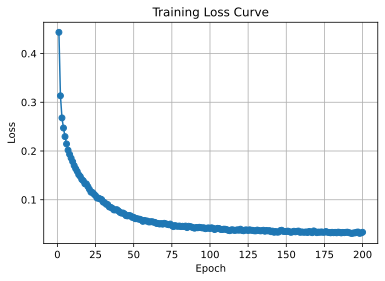

In [116]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

* 推理

In [119]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .',]
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000
